# Getting started with InferLO

In this Notebook we will review basic concepts of InferLO library, show how to define graphical models and how to solve different tasks (inference, maximum likelihood and sampling) for models. Also we will review different kinds of models (generic, pairwise and Normal Factor Graph), and show how you can use different algorithms to solve the same problem.

Purpose of this Notebook is to give understanding of how graphical models are represented in the InferLO library, rather than to be tutorial on graphical models.

In [1]:
# Don't run this cell unless you are InferLO developer and this notebook is in inferlo/docs/tutorials.
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('../..')

In [2]:
import inferlo
import numpy as np
from matplotlib import pyplot as plt

## Introduction

Essentially graphical model is a way to represent a probabilistic distribution over variables. This distribution is usually defined by non-normalized probability density function, represented as a product of factors, each factor being a function of small number of variables. Then we can define a graph describing structure of those factors (there are multiple ways to do so).

In InferLO you define a model in terms of two basic building blocks: `Variable`s and `Factor`s. First we review how you can do it by defining them explicilty.

## Defining a model

Let's start by defining a generic graphical model, which is explicitly defined by (non-normalized) probability density function. Let's say we have 4 variables $x_0, x_1, x_2, x_3$ which can take any value, and we want to represent probability distribution


$$p(x) \sim e^{x_1 \cdot x_2} \cdot |x_2+x_3| \cdot \cos(x3-x4)^2.$$

For this we will use `GenericGraphModel`. First, we should initialize the model with number of variables. Then, we will add factors add by one. 

In this case we will use `FunctionFactor`, which defines factor explicilty by indices of variables on which it depends and a function. To define such a factor we need three things: a model, indices of variables and a function. Function should take a list of values (its length must match number of variables this factor depends on) and evaluate value of this factor for given values of variables.

In [3]:
model = inferlo.GenericGraphModel(4)
model.add_factor(inferlo.FunctionFactor(model, [0, 1], lambda x: np.exp(x[0] * x[1])))
model.add_factor(inferlo.FunctionFactor(model, [1, 2], lambda x: np.abs(x[0] + x[1])))
model.add_factor(inferlo.FunctionFactor(model, [2, 3], lambda x: np.cos(x[0] - x[1])**2))

Now, we can evaluate value of the whole product at any point:

In [4]:
model.evaluate([1,2,3,4])

10.785309445728231

We can define the same model in more succint way, using symbolic expressions. Note that `*=` is just shortcut for `add_factor` and expression on the right creates a `FunctionFactor`.

In [5]:
model = inferlo.GenericGraphModel(4)
x0, x1, x2, x3 = model.get_symbolic_variables()
model *= np.exp(x0*x1)
model *= abs(x1+x2)
model *= np.cos(x2-x3)**2
model.evaluate([1,2,3,4])

10.785309445728231

## Variables and domains

In example above variables could take any real value. In practice it's useful to have variables with limited domain. You can specify domain for every individual variable in the model. Note that `model[i]` accesses `i`-th variable:

In [6]:
model = inferlo.GenericGraphModel(4)
model[0].domain = inferlo.RealDomain()
model[1].domain = inferlo.DiscreteDomain([10, 100, 1000])
model[2].domain = inferlo.DiscreteDomain.binary()
model[3].domain = inferlo.DiscreteDomain.range(5)

print([var.domain for var in model.get_variables()])

[RealDomain, DiscreteDomain([10,100,1000]), DiscreteDomain([0,1]), DiscreteDomain([0,1,2,3,4])]


In this example $x_0 \in \mathbb{R}, x_1 \in \{10, 100, 1000\}, x_2 \in \{0, 1\} , x_3 \in \{0, 1,2,3,4,5\}$. 

By default domains of all variables are real. If you want to change domains of some variables, please do so first thing after you created the model. 

If you want all variables to have the same (default) domain, you can specify this domain when creating a model.
In example below all variables are binary, except last one, which can take values 0,1 or 2.

In [7]:
model = inferlo.GenericGraphModel(5, domain=inferlo.DiscreteDomain.binary())
model[4].domain = inferlo.DiscreteDomain.range(3)
print([var.domain for var in model.get_variables()])

[DiscreteDomain([0,1]), DiscreteDomain([0,1]), DiscreteDomain([0,1]), DiscreteDomain([0,1]), DiscreteDomain([0,1,2])]


## Factors

In example above we used `FunctionFactor`, which is defined explicilty by a function, and it can be any function. There are other ways to represent factors.

If all variables, on which the fcator depends, are discrete, number of possible combinations of variable values is finite, so you can tabulate the function and represnt it by this table (which will be a multidimensional array). You can do this in InferLO by using a `DiscreteFactor`.

In [8]:
model = inferlo.GenericGraphModel(2, domain=inferlo.DiscreteDomain.binary())
factor = inferlo.DiscreteFactor(model, [0, 1], [[0, 1], [2, 3]])
factor.value([1, 0])

2

Above we described a function $f(x_0, x_1)$ such that $f(0,0)=0, f(0,1)=1, f(1,0)=2, f(1,1)=3$.

You can define a function explicilty (using `FunctionFactor`) and then convert it do `DiscreteFactor`, obtaining explict table of function values:

In [9]:
model = inferlo.GenericGraphModel(3, domain=inferlo.DiscreteDomain.binary())
model[2].domain = inferlo.DiscreteDomain([2, 3, 4])
x0, x1, x2 = model.get_symbolic_variables()
function_factor = 100 * x0 + 10 * x1 + x2
discrete_factor = inferlo.DiscreteFactor.from_factor(function_factor)
discrete_factor.values

array([[[  2.,   3.,   4.],
        [ 12.,  13.,  14.]],

       [[102., 103., 104.],
        [112., 113., 114.]]])

## Pairwise models

Generic model can express any distribution, but it's too abstract. InferLO defines classes for more concrete models, which may be subjects to some additional constraints, but allow for efficient algorithms to solve certain problems.

First such example is Pairwise Finite model - a model where every factor depends on at most 2 variables, and where variables come from the same discrete domain. Famous partial cases of this kind of model are 
[Ising model](https://en.wikipedia.org/wiki/Ising_model) and 
[Potts model](https://en.wikipedia.org/wiki/Potts_model).

In InferLO such model is represented by class `PairWiseFiniteModel`. It's defined by `gr_size` - graph size and `al_isze` - alphabet size. Domain of all variables is set of integers `0, 1, ..., al_size-1`.

Denote $N$ - `gr_size`, $T$ - `al_size`. 
Probability of given state $X \in \{0, \dots T-1 \}^{N}$ is given by formula:

$$p(X) = \frac{1}{Z} \exp \Big(
\sum_{i=0}^{N-1} F[i, X_i] + 
\sum_{u, v \in E} J_{i,j} [X_i, X_j] \Big),$$ 

where $F \in \mathbb{R}^{N, T}$ - "field", $E \in V \times V$ --- set of edges ($V = \{0, \dots, N-1\}^2$ - vertices), 
$J_{u, v} \in \mathbb{R}^{T, T}$ - interaction matrix corresponding to edge $(u, v)$.
$Z$ is normalization function, which is constant defined to ensure that $\sum_{X} p(X)=1$, also known as *partition function*.



In InferLO you can create such a model by field, all edges and interaction at once, or by setting field and individual interactions one by one. Below we show two ways to create the same model. It has 4 vertices, 3 edges, and all edges has the same interactions matrix.

In [10]:
model1 = inferlo.PairWiseFiniteModel(4, 2)
field = np.array([[1,2],[3,4],[5,6],[7,8]])
J = np.array([[-5, 5], [5, -5]])
model1.set_field(field)
model1.add_interaction(0, 1, J)
model1.add_interaction(0, 2, J)
model1.add_interaction(0, 3, J)

edges = [[0, 1], [0, 2], [0, 3]]
model2 = inferlo.PairWiseFiniteModel.create(field, edges, [J, J, J])

Now, let's can show pairwise grap for this model - this is the graph $G=(V, E)$ from definition above, where vertices represent variables and edges represent interactions.

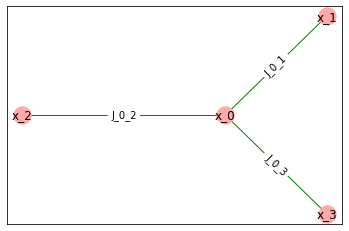

In [11]:
model1.draw_pairwise_graph(plt)

We can also draw factor graph for this model. Factor graph is a bipartite graph with variables in one part and factors in other. There is an edge between variable and factor if factor depends on that variable.

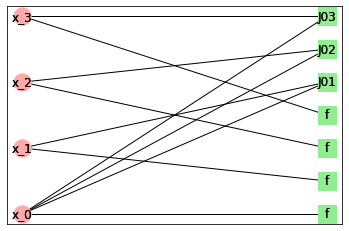

In [12]:
model1.draw_factor_graph(plt)

We can see that there are 3 factors corresponding to edges and 4 factors corresponding to fields in vertices.

## Inference, Optimization and Sampling

Now, let's do something with this toy model. First task is inference - finding partition function $Z$ and marginal probabilities.

In [13]:
model1.infer()

InferenceResult(log_pf=34.12701627818652, marg_prob=array([[0.88076347, 0.11923653],
       [0.11923653, 0.88076347],
       [0.11923653, 0.88076347],
       [0.11923653, 0.88076347]]))

In [14]:
model2.infer()

InferenceResult(log_pf=34.12701627818652, marg_prob=array([[0.88076347, 0.11923653],
       [0.11923653, 0.88076347],
       [0.11923653, 0.88076347],
       [0.11923653, 0.88076347]]))

Note that we return not parttion function, but its logarithm, because it itself may be so high that it doesn't fit in float data type.

Another task is optimization, i.e. finding state having the highest probability.

In [15]:
model1.max_likelihood()

array([0, 1, 1, 1], dtype=int32)

Yet another task is sampling - sampling realizations of distribution represented by the model. You can specify number of samples and get that many independent samples.

In [16]:
model1.sample(num_samples=3)

array([[0, 1, 1, 1],
       [0, 1, 1, 1],
       [0, 1, 1, 1]], dtype=int32)

## Algorithms

The same problem for the same model can be solved by different algorithm of different accuract and efficiency. Let's build a model whose graph is 5x5 grid and perform inference using three algorithms - dynamic programming on path decomposition (exact), mean field (approximate) and message passing (approximate).

In [17]:
from inferlo.testing import grid_potts_model
model = grid_potts_model(5, 5, al_size=3, seed=123)

result = model.infer(algorithm='path_dp')
print(result.log_pf)
print(result.marg_prob[0])

156.4906749764044
[0.41116171 0.00963484 0.57920346]


In [18]:
result = model.infer(algorithm='message_passing')
print(result.log_pf)
print(result.marg_prob[0])

6639.478242081531
[0.4127652  0.00997726 0.57725754]


In [19]:
result = model.infer(algorithm='mean_field')
print(result.log_pf)
print(result.marg_prob[0])

146.0209085386057
[0.27666686 0.00299012 0.72034302]


First answer is guaranteed to be exact. 

Message passing gives good approximation for marginal probabilities, but partion function is completely wrong (in fact, we can restore correct patition function for this algorithm only if graph is a tree).

Mean field is guaranteed to give lower bound on partition function, and we can see that estimate is close to correct answer, but estimate of marginal probablities is worse than for message passing.

## Normal Factor Graph models

If every variable appears in exactly two factors, we can build a Normal Factor Graph - a graph where edges correspond to variables, and vertices correspond to factors. We we will call such models Normal Factor Graph (NFG) models. Also they are known ad Edge-Variable or Forney-style models.

Not any model can be represented in such a way, but every model can be converted to NFG model. Conversion may add new variables and factors. This conversion is implemented by function ```inferlo.NormalFactorGraphModel.from_model```, which takes arbitrary graphical model and returns equivalent NFG model.

### Conversion to Normal Factor Graph model

Below we demonstrate how the conversion algorithm works. We build generic model with 5 variables and 4 factors. Then we convert it to equivalent Normal Factor Graph model.

We plot factor graph for initial model, Normal Factor graph and factor graph for the new model.

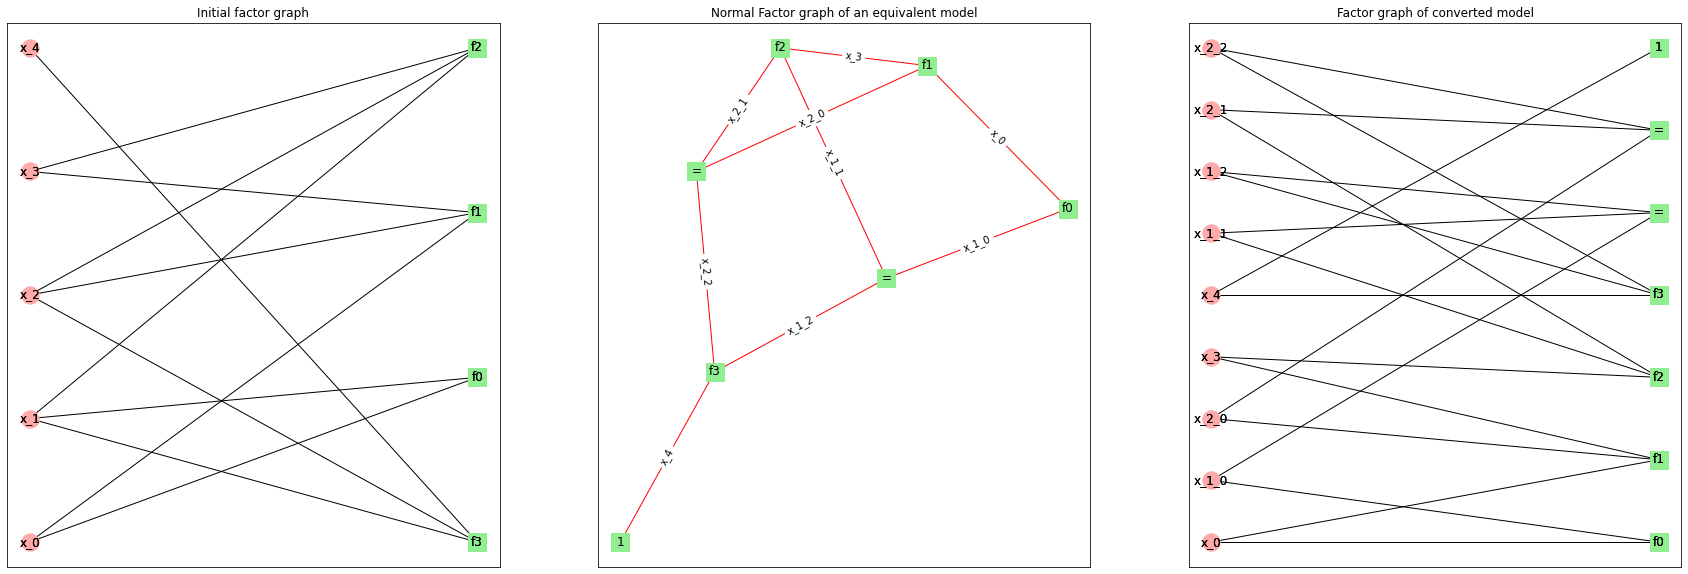

In [20]:
model1 = inferlo.GenericGraphModel(num_variables = 5)
x1, x2, x3, x4, x5 = model1.get_symbolic_variables()
model1 *= np.exp(x1*x2)
model1 *= np.exp(x1*x3*x4)
model1 *= np.exp(x2*x3*x4)
model1 *= np.exp(x2*x3*x5)

for i in range(len(model1.factors)):
    model1.factors[i].name = 'f%d' % i
    
fig = plt.figure(figsize=(30, 10))
model1.draw_factor_graph(fig.add_subplot(1, 3, 1)) 


model2 = inferlo.NormalFactorGraphModel.from_model(model1) 
model2.draw_edge_variable_graph(fig.add_subplot(1, 3, 2))
model2.draw_factor_graph(fig.add_subplot(1, 3, 3))

ax = fig.get_axes()
ax[0].set_title('Initial factor graph')
ax[1].set_title('Normal Factor graph of an equivalent model')
ax[2].set_title('Factor graph of converted model')
plt.show()

Note how each of variables $x_1$ and $x_2$ is replaced with three variables and a factor requiring new variables to be equal (denoted "="). 

Also there is a trivial factor $f(x_4)=1$ (denoted "1") which is added so that $x_4$ appears in exactly 2 factors, so we can draw an edge.

We add new variables only if necessary. If variable appears in only 1 or 2 factors, it won't be cloned.

## Three graphs of a model

Below we build a simple model which is both pairwise and NFG model, and show 3 graphs for it: pairwise graph, factor graph and Normal Factor (edge-variable) graph.


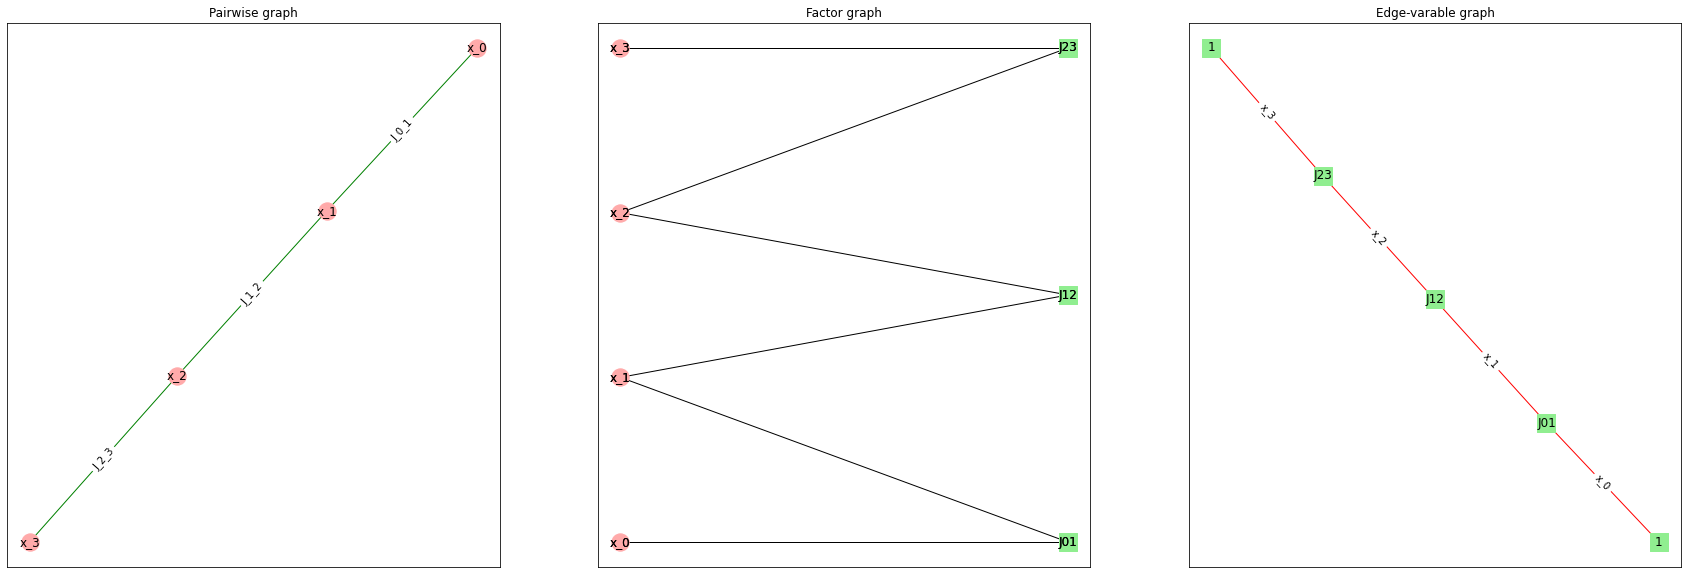

In [21]:
field = np.zeros((4, 2))
edges = [[0, 1], [1, 2], [2, 3]]
j1 = np.array([[0, 0], [0, 1]])
interactions = [j1, j1, j1]
model1 = inferlo.PairWiseFiniteModel.create(field, edges, interactions)

fig = plt.figure(figsize=(30, 10))
model1.draw_pairwise_graph(fig.add_subplot(1, 3, 1))

model1.draw_factor_graph(fig.add_subplot(1, 3, 2))

model2 = inferlo.NormalFactorGraphModel.from_model(model1) 
model2.draw_edge_variable_graph(fig.add_subplot(1, 3, 3))

ax = fig.get_axes()
ax[0].set_title('Pairwise graph')
ax[1].set_title('Factor graph')
ax[2].set_title('Edge-varable graph')
plt.show()

You can define pairwise graph only for pairwise model and Normal Factor Graph only for NFG model. Factor graph is defined for any model. 

For this example we selected model which is both pairwise and NFG. In general, we wouldn't be able to convert pairwise model to NFG model without adding.

This example demonstrates how factors and variables correspond to different elements of graph in different representations. In pairwise graph vertices are variables and edges are factors. In Normal Factor Graph vertices are factors and edges are variables. In factor graph vertices in one part are variables, and vertices in other part are factor.

Note how things representing variables are always red, and things representing factors are always green.